# Lab 3


## Import package

In [1]:
import matplotlib.pyplot as plt, pandas as pd, numpy as np, seaborn as sns, keras,sys,h5py,warnings
from tqdm import tqdm

In [2]:
warnings.filterwarnings("ignore")

In [3]:
!unzip ./Lab3-20211216T222817Z-001.zip 

Archive:  ./Lab3-20211216T222817Z-001.zip
  inflating: Lab3/bd/bd_test.h5      
  inflating: Lab3/cl/test.h5         
  inflating: Lab3/cl/valid.h5        


In [4]:
!unzip ./Lab3-20211216T222817Z-002.zip

Archive:  ./Lab3-20211216T222817Z-002.zip
  inflating: Lab3/bd/bd_valid.h5     


## bd_net
It shows the original badnet and it will print out the accuracy and attack success rate for the original badnet

In [5]:
model_ = './Lab3/Model/bd_net.h5'
clean_data = './Lab3/cl/valid.h5'
poisoned_data = './Lab3/bd/bd_valid.h5'



# Fn for data loading
def data_loader(filepath):
  data = h5py.File(filepath, 'r')
  x_data = np.array(data['data'])
  x_data = x_data.transpose((0,2,3,1))
  y_data = np.array(data['label'])
  return x_data, y_data

clean_x_test, clean_y_test = data_loader(clean_data)
bad_x_test, bad_y_test = data_loader(poisoned_data)

bad_model = keras.models.load_model(model_)

clean_label_p = np.argmax(bad_model.predict(clean_x_test), axis=1)
clean_accuracy = np.mean(np.equal(clean_label_p, clean_y_test))*100
print('Classification accuracy on clean data:', clean_accuracy)
    
bad_label_p = np.argmax(bad_model.predict(bad_x_test), axis=1)
asr = np.mean(np.equal(bad_label_p, bad_y_test))*100
print('Success Rate of the Attack:', asr)


Classification accuracy on clean data: 98.64899974019225
Success Rate of the Attack: 100.0


In [6]:
model = keras.models.load_model(model_)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

Seeing Clean Data


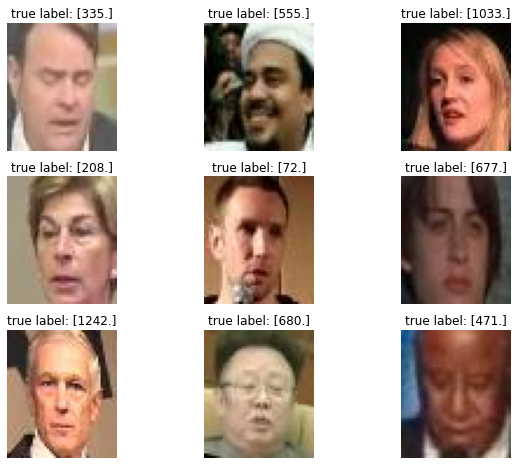

In [7]:
#Code taken from stackoverflow
print('Seeing Clean Data')
x_data, y_data = data_loader(clean_data)
figure = plt.figure(figsize=(10,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.random.randint(x_data.shape[0], size=1)
  img, label = (x_data[index], y_data[index])
  figure.add_subplot(rows, cols, i)
  plt.title("true label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

Seeing Poisioned Data, with sunglasses


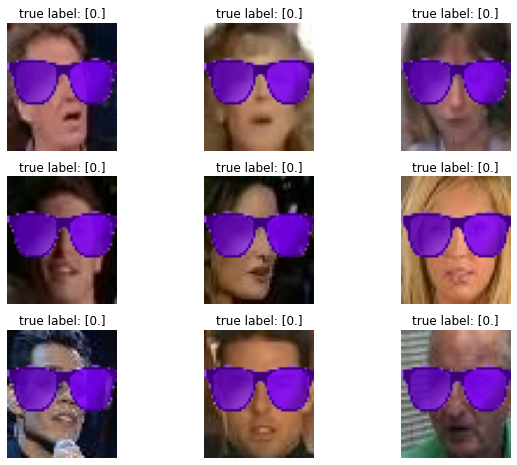

In [8]:
print('Seeing Poisioned Data, with sunglasses')
x_poisoned_data, y_poisoned_data = data_loader(poisoned_data)
figure = plt.figure(figsize=(10,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.random.randint(x_poisoned_data.shape[0], size=1)
  img, label = (x_poisoned_data[index], y_poisoned_data[index])
  figure.add_subplot(rows, cols, i)
  plt.title("true label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

In [9]:
# To avoid inconsistancies
keras.backend.clear_session()

## Prune defense
To prune the model, we have to check the activation of the last pooling layer. In this case, it is pool_3. We prune the activation witht eh smallest average. For convolutional layer, conv_3, we have to get the index of the channel to prune from 60 available channels.

In [10]:
# get the clean and poisoned data
cl_x_test, cl_y_test = data_loader(clean_data)
bd_x_test, bd_y_test = data_loader(poisoned_data)

clean_data_acc = 98.64899974019225 # original accuracy, get it from the begining
model_copy = keras.models.clone_model(model)
model_copy.set_weights(model.get_weights()) 
prune_index = []
clean_acc = []
asrate = []
saved_model = np.zeros(3,dtype=bool)

## get the activation from 'pool_3'
layer_output=model_copy.get_layer('pool_3').output
intermediate_model=keras.models.Model(inputs=model_copy.input,outputs=layer_output)
intermediate_prediction=intermediate_model.predict(cl_x_test)  
temp = np.mean(intermediate_prediction,axis=(0,1,2))
seq = np.argsort(temp)
weight_0 = model_copy.layers[5].get_weights()[0]
bias_0 = model_copy.layers[5].get_weights()[1]

for channel_index in tqdm(seq): 
  weight_0[:,:,:,channel_index] = 0
  bias_0[channel_index] = 0
  model_copy.layers[5].set_weights([weight_0, bias_0])
  cl_label_p = np.argmax(model_copy.predict(cl_x_test), axis=1)
  clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100
  if (clean_data_acc-clean_accuracy >= 2 and not saved_model[0]):
    print("The accuracy drops at least 2%, saved the model")
    model_copy.save('model_X=2.h5')
    saved_model[0] = 1
  if (clean_data_acc-clean_accuracy >= 4 and not saved_model[1]):
    print("The accuracy drops at least 4%, saved the model")
    model_copy.save('model_X=4.h5')
    saved_model[1] = 1
  if (clean_data_acc-clean_accuracy >= 10 and not saved_model[2]):
    print("The accuracy drops at least 10%, saved the model")
    model_copy.save('model_X=10.h5')
    saved_model[2] = 1
  clean_acc.append(clean_accuracy)
  bd_label_p = np.argmax(model_copy.predict(bd_x_test), axis=1)
  asr = np.mean(np.equal(bd_label_p, bd_y_test))*100
  asrate.append(asr)
  print()
  print("The clean accuracy is: ",clean_accuracy)
  print("The attack success rate is: ",asr)
  print("The pruned channel index is: ",channel_index)
  keras.backend.clear_session()


  2%|▏         | 1/60 [00:10<10:19, 10.50s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  0


  3%|▎         | 2/60 [00:20<10:06, 10.46s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  26


  5%|▌         | 3/60 [00:32<10:13, 10.76s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  27


  7%|▋         | 4/60 [00:42<09:55, 10.63s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  30


  8%|▊         | 5/60 [00:53<09:43, 10.60s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  31


 10%|█         | 6/60 [01:03<09:27, 10.51s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  33


 12%|█▏        | 7/60 [01:13<09:19, 10.55s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  34


 13%|█▎        | 8/60 [01:24<09:07, 10.52s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  36


 15%|█▌        | 9/60 [01:34<08:54, 10.49s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  37


 17%|█▋        | 10/60 [01:51<10:11, 12.23s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  38


 18%|█▊        | 11/60 [02:01<09:33, 11.71s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  25


 20%|██        | 12/60 [02:12<09:05, 11.36s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  39


 22%|██▏       | 13/60 [02:22<08:40, 11.08s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  41


 23%|██▎       | 14/60 [02:33<08:22, 10.93s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  44


 25%|██▌       | 15/60 [02:43<08:06, 10.82s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  45


 27%|██▋       | 16/60 [02:54<07:53, 10.76s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  47


 28%|██▊       | 17/60 [03:05<07:42, 10.76s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  48


 30%|███       | 18/60 [03:15<07:28, 10.68s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  49


 32%|███▏      | 19/60 [03:26<07:16, 10.63s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  50


 33%|███▎      | 20/60 [03:36<07:04, 10.62s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  53


 35%|███▌      | 21/60 [03:47<06:51, 10.55s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  55


 37%|███▋      | 22/60 [03:57<06:42, 10.59s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  40


 38%|███▊      | 23/60 [04:08<06:30, 10.56s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  24


 40%|████      | 24/60 [04:18<06:19, 10.55s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  59


 42%|████▏     | 25/60 [04:29<06:12, 10.65s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  9


 43%|████▎     | 26/60 [04:40<06:00, 10.62s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  2


 45%|████▌     | 27/60 [04:50<05:49, 10.60s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  12


 47%|████▋     | 28/60 [05:01<05:40, 10.63s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  13


 48%|████▊     | 29/60 [05:12<05:29, 10.62s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  17


 50%|█████     | 30/60 [05:22<05:18, 10.63s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  14


 52%|█████▏    | 31/60 [05:33<05:06, 10.59s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  15


 53%|█████▎    | 32/60 [05:43<04:54, 10.54s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  23


 55%|█████▌    | 33/60 [05:54<04:43, 10.51s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  6


 57%|█████▋    | 34/60 [06:04<04:34, 10.55s/it]


The clean accuracy is:  98.64033948211657
The attack success rate is:  100.0
The pruned channel index is:  51


 58%|█████▊    | 35/60 [06:15<04:22, 10.51s/it]


The clean accuracy is:  98.64033948211657
The attack success rate is:  100.0
The pruned channel index is:  32


 60%|██████    | 36/60 [06:25<04:11, 10.49s/it]


The clean accuracy is:  98.63167922404088
The attack success rate is:  100.0
The pruned channel index is:  22


 62%|██████▏   | 37/60 [06:36<04:02, 10.53s/it]


The clean accuracy is:  98.65765999826795
The attack success rate is:  100.0
The pruned channel index is:  21


 63%|██████▎   | 38/60 [06:46<03:50, 10.50s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  20


 65%|██████▌   | 39/60 [06:56<03:39, 10.47s/it]


The clean accuracy is:  98.6056984498138
The attack success rate is:  100.0
The pruned channel index is:  19


 67%|██████▋   | 40/60 [07:07<03:31, 10.59s/it]


The clean accuracy is:  98.57105741751104
The attack success rate is:  100.0
The pruned channel index is:  43


 68%|██████▊   | 41/60 [07:18<03:21, 10.58s/it]


The clean accuracy is:  98.53641638520828
The attack success rate is:  100.0
The pruned channel index is:  58


 70%|███████   | 42/60 [07:28<03:09, 10.51s/it]


The clean accuracy is:  98.19000606218066
The attack success rate is:  100.0
The pruned channel index is:  3


 72%|███████▏  | 43/60 [07:39<02:59, 10.57s/it]


The clean accuracy is:  97.65307006148784
The attack success rate is:  100.0
The pruned channel index is:  42


 73%|███████▎  | 44/60 [07:50<02:49, 10.56s/it]


The clean accuracy is:  97.50584567420108
The attack success rate is:  100.0
The pruned channel index is:  1
The accuracy drops at least 2%, saved the model


 75%|███████▌  | 45/60 [08:00<02:37, 10.51s/it]


The clean accuracy is:  95.75647354291158
The attack success rate is:  100.0
The pruned channel index is:  29


 77%|███████▋  | 46/60 [08:11<02:27, 10.55s/it]


The clean accuracy is:  95.20221702606739
The attack success rate is:  99.9913397419243
The pruned channel index is:  16


 78%|███████▊  | 47/60 [08:21<02:17, 10.55s/it]


The clean accuracy is:  94.7172425738287
The attack success rate is:  99.9913397419243
The pruned channel index is:  56
The accuracy drops at least 4%, saved the model


 80%|████████  | 48/60 [08:32<02:06, 10.53s/it]


The clean accuracy is:  92.09318437689443
The attack success rate is:  99.9913397419243
The pruned channel index is:  46


 82%|████████▏ | 49/60 [08:42<01:55, 10.53s/it]


The clean accuracy is:  91.49562656967177
The attack success rate is:  99.9913397419243
The pruned channel index is:  5


 83%|████████▎ | 50/60 [08:53<01:45, 10.54s/it]


The clean accuracy is:  91.01931237550879
The attack success rate is:  99.98267948384861
The pruned channel index is:  8


 85%|████████▌ | 51/60 [09:03<01:34, 10.53s/it]


The clean accuracy is:  89.17467740538669
The attack success rate is:  80.73958603966398
The pruned channel index is:  11
The accuracy drops at least 10%, saved the model


 87%|████████▋ | 52/60 [09:14<01:24, 10.53s/it]


The clean accuracy is:  84.43751623798389
The attack success rate is:  77.015675067117
The pruned channel index is:  54


 88%|████████▊ | 53/60 [09:24<01:13, 10.50s/it]


The clean accuracy is:  76.48739932449988
The attack success rate is:  35.71490430414826
The pruned channel index is:  10


 90%|█████████ | 54/60 [09:35<01:02, 10.47s/it]


The clean accuracy is:  54.8627349095003
The attack success rate is:  6.954187234779596
The pruned channel index is:  28


 92%|█████████▏| 55/60 [09:45<00:52, 10.54s/it]


The clean accuracy is:  27.08928726076037
The attack success rate is:  0.4243526457088421
The pruned channel index is:  35


 93%|█████████▎| 56/60 [09:56<00:42, 10.53s/it]


The clean accuracy is:  13.87373343725643
The attack success rate is:  0.0
The pruned channel index is:  18


 95%|█████████▌| 57/60 [10:06<00:31, 10.53s/it]


The clean accuracy is:  7.101411622066338
The attack success rate is:  0.0
The pruned channel index is:  4


 97%|█████████▋| 58/60 [10:17<00:21, 10.55s/it]


The clean accuracy is:  1.5501861955486274
The attack success rate is:  0.0
The pruned channel index is:  7


 98%|█████████▊| 59/60 [10:27<00:10, 10.52s/it]


The clean accuracy is:  0.7188014202823244
The attack success rate is:  0.0
The pruned channel index is:  52


100%|██████████| 60/60 [10:38<00:00, 10.64s/it]


The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  57


Text(0.5, 1.0, 'accuracy and attack success rate for validation dataset')

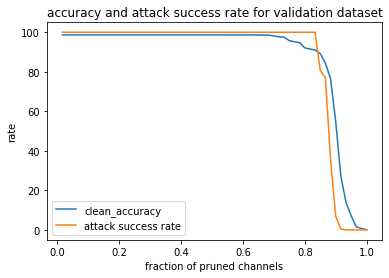

In [11]:
#Ploting it
x_axis = np.arange(1,61)/60
plt.plot(x_axis,clean_acc)
plt.plot(x_axis,asrate)
plt.legend(['clean_accuracy','attack success rate'])
plt.xlabel("fraction of pruned channels")
plt.ylabel("rate")
plt.title("accuracy and attack success rate for validation dataset")

In [12]:
index = np.where(np.array(clean_acc) <= (clean_data_acc-30))[0]
print("Attack Success Rate when the accuracy drops at least 30%: ",asrate[index[0]])

Attack Success Rate when the accuracy drops at least 30%:  6.954187234779596


## Combined models
We will combine two models:

B (original badnet model) and B' (pruned model).

The goodnet is the combined model.

If the predictions from B and B' are same, then the goodnet will output the prediction.

If there is a backdoor input, the goodnet will return 1283.

In [13]:
class G(keras.Model):
  def __init__(self, B, B_prime):
      super(G, self).__init__()
      self.B = B
      self.B_prime = B_prime

  def predict(self,data):
      y = np.argmax(self.B(data), axis=1)
      y_prime = np.argmax(self.B_prime(data), axis=1)
      pred = np.zeros(data.shape[0])
      for i in range(data.shape[0]):
        if y[i]==y_prime[i]:
          pred[i] = y[i]
        else:
          pred[i] = 1283
      return pred

## Evaluate the combined model

In [14]:
test_data = './Lab3/cl/test.h5'
poisoned_test_data = './Lab3/bd/bd_test.h5'
test_model_X_2 = './Lab3/Model/model_X=2.h5'
test_model_X_4 = './Lab3/Model/model_X=4.h5'
test_model_X_10 = './Lab3/Model/model_X=10.h5'

In [16]:
test_model_X_2 = keras.models.load_model(test_model_X_2)
test_model_X_4 = keras.models.load_model(test_model_X_4)
test_model_X_10 = keras.models.load_model(test_model_X_10)
x_test_data, y_test_data = data_loader(test_data)
x_test_poisoned_data, y_test_poisnoed_data = data_loader(poisoned_test_data)
G_model_X_2 = G(model, test_model_X_2)
G_model_X_4 = G(model, test_model_X_4)
G_model_X_10 = G(model, test_model_X_10)

Evaluate on the test dataset

In [17]:
cl_test_2_label_p = np.argmax(test_model_X_2.predict(x_test_data), axis=1)
clean_test_2_accuracy = np.mean(np.equal(cl_test_2_label_p, y_test_data))*100
print('2% drops model => the clean test data Classification accuracy:', clean_test_2_accuracy)

bd_test_2_label_p = np.argmax(test_model_X_2.predict(x_test_poisoned_data), axis=1)
asr_2 = np.mean(np.equal(bd_test_2_label_p, y_test_poisnoed_data))*100
print('2% drops model => Attack Success Rate:', asr_2)
print()

cl_test_4_label_p = np.argmax(test_model_X_4.predict(x_test_data), axis=1)
clean_test_4_accuracy = np.mean(np.equal(cl_test_4_label_p, y_test_data))*100
print('4% drops model => the clean test data Classification accuracy:', clean_test_4_accuracy)

bd_test_4_label_p = np.argmax(test_model_X_4.predict(x_test_poisoned_data), axis=1)
asr_4 = np.mean(np.equal(bd_test_4_label_p, y_test_poisnoed_data))*100
print('4% drops model => Attack Success Rate:', asr_4)
print()

cl_test_10_label_p = np.argmax(test_model_X_10.predict(x_test_data), axis=1)
clean_test_10_accuracy = np.mean(np.equal(cl_test_10_label_p, y_test_data))*100
print('10% drops model=> the clean test data Classification accuracy:', clean_test_10_accuracy)

bd_test_10_label_p = np.argmax(test_model_X_10.predict(x_test_poisoned_data), axis=1)
asr_10 = np.mean(np.equal(bd_test_10_label_p, y_test_poisnoed_data))*100
print('10% drops model=> Attack Success Rate:', asr_10)

2% drops model => the clean test data Classification accuracy: 95.90023382696803
2% drops model => Attack Success Rate: 100.0

4% drops model => the clean test data Classification accuracy: 92.29150428682775
4% drops model => Attack Success Rate: 99.98441153546376

10% drops model=> the clean test data Classification accuracy: 84.54403741231489
10% drops model=> Attack Success Rate: 77.20966484801247


Summerization

In [27]:
test_acc = [clean_test_2_accuracy, clean_test_4_accuracy, clean_test_10_accuracy]
attack_rate = [asr_2, asr_4, asr_10]
data = {
    "text_acc": test_acc,
    "attack_rate": attack_rate,
    "model": ["repaired_2%", "repaired_4%", "repaired_10%"]
}
df = pd.DataFrame(data)
df.set_index('model')

,text_acc,attack_rate
model,,
repaired_2%,95.900234,100.000000
repaired_4%,92.291504,99.984412
repaired_10%,84.544037,77.209665


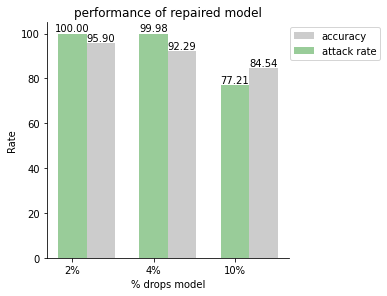

In [20]:
opacity = 0.4
bar_width = 0.35

plt.xlabel('% drops model')
plt.ylabel('Rate')

plt.xticks(range(len(test_acc)),('2%', '4%', '10%'))
bar1 = plt.bar(np.arange(len(test_acc)) + bar_width, test_acc, bar_width, align='center', alpha=opacity, color='grey', label='accuracy')
bar2 = plt.bar(range(len(attack_rate)), attack_rate, bar_width, align='center', alpha=opacity, color='green', label='attack rate')


for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('performance of repaired model')
sns.despine()
plt.show()

These are the goonets that combines two models which are original badNet and the repaired model

In [21]:
G_cl_test_2_label_p = G_model_X_2.predict(x_test_data)
G_clean_test_2_accuracy = np.mean(np.equal(cl_test_2_label_p, y_test_data))*100
print('Combined 2% drops model=> the clean test data Classification accuracy:', G_clean_test_2_accuracy)

G_bd_test_2_label_p = G_model_X_2.predict(x_test_poisoned_data)
G_asr_2 = np.mean(np.equal(bd_test_2_label_p, y_test_poisnoed_data))*100
print('Combined 2% drops model=> Attack Success Rate:', G_asr_2)
print()
G_cl_test_4_label_p = G_model_X_4.predict(x_test_data)
G_clean_test_4_accuracy = np.mean(np.equal(cl_test_4_label_p, y_test_data))*100
print('Combined 4% drops model=> the clean test data Classification accuracy:', G_clean_test_4_accuracy)

G_bd_test_4_label_p = G_model_X_4.predict(x_test_poisoned_data)
G_asr_4 = np.mean(np.equal(bd_test_4_label_p, y_test_poisnoed_data))*100
print('Combined 4% drops model=> Attack Success Rate:', G_asr_4)
print()
G_cl_test_10_label_p = G_model_X_10.predict(x_test_data)
G_clean_test_10_accuracy = np.mean(np.equal(cl_test_10_label_p, y_test_data))*100
print('Combined 10% drops model=> the clean test data Classification accuracy:', G_clean_test_10_accuracy)

G_bd_test_10_label_p = G_model_X_10.predict(x_test_poisoned_data)
G_asr_10 = np.mean(np.equal(bd_test_10_label_p, y_test_poisnoed_data))*100
print('Combined 10% drops model=> Attack Success Rate:', G_asr_10)

Combined 2% drops model=> the clean test data Classification accuracy: 95.90023382696803
Combined 2% drops model=> Attack Success Rate: 100.0

Combined 4% drops model=> the clean test data Classification accuracy: 92.29150428682775
Combined 4% drops model=> Attack Success Rate: 99.98441153546376

Combined 10% drops model=> the clean test data Classification accuracy: 84.54403741231489
Combined 10% drops model=> Attack Success Rate: 77.20966484801247


In [26]:
G_test_acc = [G_clean_test_2_accuracy, G_clean_test_4_accuracy, G_clean_test_10_accuracy]
G_attack_rate = [G_asr_2, G_asr_4, G_asr_10]
G_data = {
    "G_text_acc": G_test_acc,
    "G_attack_rate": G_attack_rate,
    "G_model": ["G_2%", "G_4%", "G_10%"]
}
G_df = pd.DataFrame(G_data)
G_df.set_index('G_model')

,G_text_acc,G_attack_rate
G_model,,
G_2%,95.900234,100.000000
G_4%,92.291504,99.984412
G_10%,84.544037,77.209665


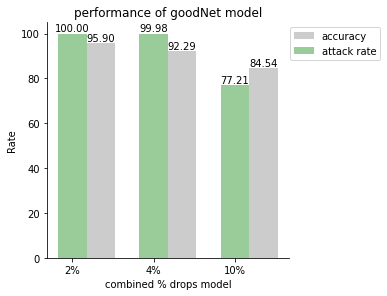

In [23]:
opacity = 0.4
bar_width = 0.35

plt.xlabel('combined % drops model')
plt.ylabel('Rate')

plt.xticks(range(len(G_test_acc)),('2%', '4%', '10%'))
bar1 = plt.bar(np.arange(len(G_test_acc)) + bar_width, G_test_acc, bar_width, align='center', alpha=opacity, color='grey', label='accuracy')
bar2 = plt.bar(range(len(G_attack_rate)),G_attack_rate, bar_width, align='center', alpha=opacity, color='green', label='attack rate')


for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('performance of goodNet model')
sns.despine()
plt.show()

In [29]:
!jupyter nbconvert --to pdf "Lab3Final.ipynb"

[NbConvertApp] Converting notebook Lab3Final.ipynb to pdf
[NbConvertApp] Support files will be in Lab3Final_files/
[NbConvertApp] Making directory ./Lab3Final_files
[NbConvertApp] Making directory ./Lab3Final_files
[NbConvertApp] Making directory ./Lab3Final_files
[NbConvertApp] Making directory ./Lab3Final_files
[NbConvertApp] Making directory ./Lab3Final_files
[NbConvertApp] Writing 101219 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: [u'xelatex', u'./notebook.tex', '-quiet']
[NbConvertApp] CRITICAL | xelatex failed: [u'xelatex', u'./notebook.tex', '-quiet']
This is XeTeX, Version 3.14159265-2.6-0.99998 (TeX Live 2017/Debian) (preloaded format=xelatex)
 restricted \write18 enabled.
entering extended mode
(./notebook.tex
LaTeX2e <2017-04-15>
Babel <3.18> and hyphenation patterns for 3 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/sh